In [2]:
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import config

In [2]:
client_credentials_manager = SpotifyClientCredentials(
    client_id=config.client_id,
    client_secret=config.client_secret
)

sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

In [44]:
me = sp.user("124718095")

In [46]:
my_playlists = sp.user_playlists(me['id'])

In [56]:
my_playlist_ids = {x['name']:x['id'] for x in my_playlists['items']}

In [59]:
my_playlist_ids['Your Top Songs 2019']

'37i9dQZF1Ethx9AjQdjLEb'

In [60]:
top_songs_2019 = sp.playlist_tracks(my_playlist_ids['Your Top Songs 2019'])

In [77]:
top_songs_2019_ids = {x['track']['name']:x['track']['id'] for x in top_songs_2019['items']}

## track features 

In [14]:
q = sp.search(q='Del Water Gap',type='artist')['artists']['items']
q

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0xPoVNPnxIIUS1vrxAYV00'},
  'followers': {'href': None, 'total': 19109},
  'genres': ['deep new americana'],
  'href': 'https://api.spotify.com/v1/artists/0xPoVNPnxIIUS1vrxAYV00',
  'id': '0xPoVNPnxIIUS1vrxAYV00',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/e628ab91e4ffacc38932adef0b72c1b8c6eae66a',
    'width': 640},
   {'height': 320,
    'url': 'https://i.scdn.co/image/3dcac05d36e7f2290d912e3bbaf2760b47bc985e',
    'width': 320},
   {'height': 160,
    'url': 'https://i.scdn.co/image/2be8f2fe4c36b9f5aac339e4ed6b9a91b49cf255',
    'width': 160}],
  'name': 'Del Water Gap',
  'popularity': 50,
  'type': 'artist',
  'uri': 'spotify:artist:0xPoVNPnxIIUS1vrxAYV00'}]

In [19]:
dwg_id = q[0]['id']

In [97]:
def get_artistTracks(artist_name=None,artist_id=None):
    if artist_name:
        artist = sp.search(q=artist_name,type='artist')['artists']['items'][0]
        artist_id = artist['id']
    albums = sp.artist_albums(artist['id'])['items']
    
    album_ids = [ 
        {'id':x['id'],'album_name':x['name']} for x in albums 
    ]
    
    album_tracks = [ sp.album_tracks(x['id']) for x in album_ids ]
    
    # item for sublist in list for item in sublist 
    tracks = [ 
        {
            'name':item['name'],
            'id':item['id'],
            'artists':[x['name'] for x in item['artists']]
        }
        for album in album_tracks 
        for item in album['items']
        if artist['name'] in [ x['name'] for x in item['artists'] ]
    ]
    
    return tracks

In [99]:
del_water_tracks = get_artistTracks(artist_name='Del Water Gap')

In [101]:
del_water_tracks[:5]

[{'name': "Don't Say Nothing - live in Fresno",
  'id': '4iCAH9P6e4ilKhc60qcRJv',
  'artists': ['Del Water Gap']},
 {'name': 'Theory of Emotion - live in Fresno',
  'id': '1jdcKxb3I3rzQUYZyekCgr',
  'artists': ['Del Water Gap']},
 {'name': 'Chastain - live in Fresno',
  'id': '519l7sJ9H0vshmI2X4rgQL',
  'artists': ['Del Water Gap']},
 {'name': 'To Philly - live in Fresno',
  'id': '3IAcmRXOPwmDLht8UDDrYp',
  'artists': ['Del Water Gap']},
 {'name': 'Laid Down My Arms - live in Fresno',
  'id': '5sYmFFLcruE6zBaO55Cl7d',
  'artists': ['Del Water Gap']}]

In [105]:
records = []
for track in del_water_tracks:
    audio_features = sp.audio_features(track['id'])[0]
    audio_features['artists'] = track['artists']
    audio_features['name'] = track['name']
    records.append(audio_features)

In [107]:
df = pd.DataFrame.from_records(records)

In [119]:
df.drop(columns=['track_href','analysis_url','type','uri'],inplace=True)

In [115]:
df['artists'] = df.apply(lambda x : "".join([artist+', ' for artist in x['artists']]).strip(', '),axis=1)

In [109]:
trs = sp.tracks(df['id'].to_list())

In [110]:
#df['popularity'] = df['id'].map({x['id']:x['popularity'] for x in trs['tracks']})

In [111]:
df['release_date'] = df['id'].map({x['id']:x['album']['release_date'] for x in trs['tracks']})

In [116]:
df.sort_values(by='release_date',axis=0,inplace=True)

In [124]:
df.drop_duplicates([x for x in df.columns if x not in ['release_date','name','id']],keep='first',inplace=True)

In [140]:
#df.drop(index=19,inplace=True)
df.reset_index(inplace=True,drop=True)

In [142]:
df['name']

0                              In the Yard
1                  Be My Own (Bonus Track)
2            I Am Drunk, And She Is Insane
3                                 Homeless
4              Lost My Cat / Put in a Cage
5                           Rockman's Pier
6                            Still in Love
7                                Lamplight
8                             Cut the Rope
9                                  Vanessa
10                               High Tops
11                Love Song for Lady Earth
12                           Let's Pretend
13                          Deirdre, Pt. I
14                   Don't Read the Mirror
15                    High Tops (Stripped)
16                       Laid Down My Arms
17                                Chastain
18                       Theory of Emotion
19                            Don't Let Me
20                       Don't Say Nothing
21                               To Philly
22                       Laid Down My Arms
23         

In [146]:
with_charlie = [
    'I Am Drunk, And She Is Insane', 'Lost My Cat / Put in a Cage', 
    "Rockman's Pier", 'Still in Love', 'Lamplight', 'Cut the Rope', 
    'Vanessa', 'High Tops', 'Love Song for Lady Earth', "Let's Pretend",
    'Deirdre, Pt. I', "Don't Read the Mirror", 'Laid Down My Arms','Theory of Emotion'
]

In [160]:
not_charlie = df[~df['name'].isin(with_charlie)]['valence']

In [161]:
charlie = df[df['name'].isin(with_charlie)]['valence']

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

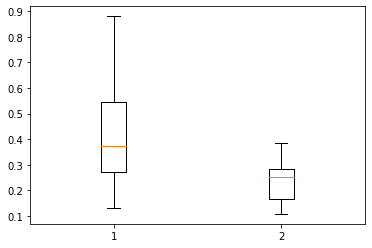

In [165]:
fig, ax = plt.subplots()
ax.boxplot([charlie,not_charlie])

plt.show()

In [157]:
ax.boxplot(x)

{'whiskers': [<matplotlib.lines.Line2D at 0x12132a3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1214e3f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x1214dc2e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1214edc18>],
 'fliers': [<matplotlib.lines.Line2D at 0x1214f4710>],
 'means': []}

## by playlist

In [324]:
sam_playlists = sp.user_playlists(1250134147)

In [340]:
sam_playlist_ids = [
    {'playlist_id':x['id'],'playlist_name':x['name']} for x in sam_playlists['items']]

In [341]:
sam_playlist_ids

[{'playlist_id': '0ti4xxabrASrUfndyMAM84', 'playlist_name': 'the end'},
 {'playlist_id': '4onXnKlx8zqSBFMoegjnTX',
  'playlist_name': 'wfh: pandemic edition'},
 {'playlist_id': '5pSaH0lwwMZQv4icmvLODy', 'playlist_name': 'working'},
 {'playlist_id': '5x3kN5QBau7m55CDq31jxY', 'playlist_name': 'hbd, dave'},
 {'playlist_id': '4yhHSqzDCxttvBEfMBOODi',
  'playlist_name': 'unpretentious resort wave'},
 {'playlist_id': '6jmzGHmwwueGgqw376qJku',
  'playlist_name': 'all killer no filler'},
 {'playlist_id': '2VBPgWKiFM2N5lXEFYp7sk',
  'playlist_name': 'The Wry Young Women Writing Sad, Buoyant, Beautiful Songs'}]

In [359]:
import time

In [360]:
records = []
for playlist in sam_playlist_ids:
    playlist_items = sp.playlist_tracks(playlist['playlist_id'])['items']
    track_ids = [item['track']['id'] for item in playlist_items]
    
    audio_features = [sp.audio_features(x)[0] for x in track_ids]
    for track in audio_features:
        track['playlist_name']=playlist['playlist_name']
    records.extend(audio_features)
    time.sleep(5)

In [364]:
playlist_df = pd.DataFrame.from_records(records)

In [366]:
playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,playlist_name
0,0.459,0.617,8,-5.810,1,0.0353,0.000056,0.354000,0.0443,0.522,117.959,audio_features,1qoqz2LrkRl2A24OSdp6wI,spotify:track:1qoqz2LrkRl2A24OSdp6wI,https://api.spotify.com/v1/tracks/1qoqz2LrkRl2...,https://api.spotify.com/v1/audio-analysis/1qoq...,208967,4,the end
1,0.381,0.436,5,-6.731,1,0.0329,0.011800,0.000000,0.1330,0.453,183.923,audio_features,2guw9QqCoBNGlJTPQBAAHk,spotify:track:2guw9QqCoBNGlJTPQBAAHk,https://api.spotify.com/v1/tracks/2guw9QqCoBNG...,https://api.spotify.com/v1/audio-analysis/2guw...,149077,3,the end
2,0.468,0.635,8,-7.079,1,0.0273,0.000202,0.446000,0.1100,0.249,103.946,audio_features,6OHVsfC65IdO9MM8oQPthL,spotify:track:6OHVsfC65IdO9MM8oQPthL,https://api.spotify.com/v1/tracks/6OHVsfC65IdO...,https://api.spotify.com/v1/audio-analysis/6OHV...,159940,4,the end
3,0.262,0.651,9,-8.413,1,0.0322,0.000070,0.020200,0.0883,0.175,100.463,audio_features,2Lk6WptvmyH5SN73Pi4vZx,spotify:track:2Lk6WptvmyH5SN73Pi4vZx,https://api.spotify.com/v1/tracks/2Lk6WptvmyH5...,https://api.spotify.com/v1/audio-analysis/2Lk6...,237823,4,the end
4,0.377,0.499,9,-7.228,1,0.0323,0.002350,0.007680,0.1180,0.412,173.595,audio_features,52bYAaDo17L4JNdkBZ1rIw,spotify:track:52bYAaDo17L4JNdkBZ1rIw,https://api.spotify.com/v1/tracks/52bYAaDo17L4...,https://api.spotify.com/v1/audio-analysis/52bY...,206672,4,the end
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.181,0.653,5,-5.102,1,0.0380,0.366000,0.000085,0.1600,0.371,204.164,audio_features,3Nb8Fqfi1N01eAASK9jduB,spotify:track:3Nb8Fqfi1N01eAASK9jduB,https://api.spotify.com/v1/tracks/3Nb8Fqfi1N01...,https://api.spotify.com/v1/audio-analysis/3Nb8...,161600,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
233,0.459,0.824,5,-5.296,1,0.0399,0.007650,0.003540,0.1670,0.355,126.352,audio_features,5Ap9hgpKbDugMg7dQmtKgm,spotify:track:5Ap9hgpKbDugMg7dQmtKgm,https://api.spotify.com/v1/tracks/5Ap9hgpKbDug...,https://api.spotify.com/v1/audio-analysis/5Ap9...,180800,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
234,0.538,0.275,2,-8.015,1,0.0278,0.661000,0.000033,0.1450,0.186,97.548,audio_features,64sDUuHnNZgo5cnhVq9lIg,spotify:track:64sDUuHnNZgo5cnhVq9lIg,https://api.spotify.com/v1/tracks/64sDUuHnNZgo...,https://api.spotify.com/v1/audio-analysis/64sD...,152267,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."
235,0.279,0.777,6,-3.922,1,0.0462,0.183000,0.761000,0.0874,0.605,118.977,audio_features,3kLsqsxZ9DDwmllHisvK92,spotify:track:3kLsqsxZ9DDwmllHisvK92,https://api.spotify.com/v1/tracks/3kLsqsxZ9DDw...,https://api.spotify.com/v1/audio-analysis/3kLs...,218400,4,"The Wry Young Women Writing Sad, Buoyant, Beau..."


In [239]:
def audioFeatures_byArtist(name=None,artist_id=None,track_ids=None,playlist=None):
    pass

### scraping for billboard charts 

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
page = requests.get("http://billboardtop100of.com/2019-2/")

In [8]:
bs = BeautifulSoup(page.content)

In [9]:
p_tags = bs.find_all('p')

text = [p.getText(strip=True) for p in p_tags]

records = []
for n,p_tag in enumerate(p_tags):
    try:
        record = {
            "rank":int(p_tag.getText(strip=True)),
            "song":p_tags[n+1].getText(strip=True),
            "artist":p_tags[n+2].getText(strip=True),
            "year":2019
        }
        records.append(record)
    except:
        continue 

In [50]:
len(records)

100

In [13]:
def scrape_top100(year):
    year = str(year)
    
    page = requests.get(f"http://billboardtop100of.com/{year}-2/")
    bs = BeautifulSoup(page.content)
    
    # first try 
    p_tags = bs.find_all('p')

    text = [p.getText(strip=True) for p in p_tags]

    records = []
    for n,p_tag in enumerate(p_tags):
        try:
            record = {
                "rank":int(p_tag.getText(strip=True)),
                "song":p_tags[n+1].getText(strip=True),
                "artist":p_tags[n+2].getText(strip=True),
                "year":year
            }
            records.append(record)
        except:
            continue 
    
    if len(records)==100:
        return records
    else: #<-- if the first method didn't work..
        # second method
        ranks = [x.getText(strip=True) for x in bs.find_all(attrs={'class':"ye-chart-item__rank"})]

        songs = [x.getText(strip=True) for x in bs.find_all(attrs={'class':"ye-chart-item__title"})]

        artists = [x.getText(strip=True) for x in bs.find_all(attrs={'class':"ye-chart-item__artist"})]
    
        records = [{'rank':rank,'song':song,'artist':artist,'year':year} for rank,song,artist in zip(ranks,songs,artists)]
        
        if len(records)==100:
            return records
        else:
            # 3rd method
            dfs = pd.read_html(f"http://billboardtop100of.com/{year}-2/")
            df=dfs[0]
            df.columns = ['rank','artist','song']
            df['year']=year
            records = df.to_dict(orient='records')
            if len(records)==100:
                return records
            

In [15]:
records = []
errors = []
for year in list(range(2000,2020)):
    try:
        records.extend(scrape_top100(year))
        print('o')
    except:
        print("x")
        errors.append(year)

o
o
o
o
o
o
o
o
o
o
o
o
o
x
o
o
o
o
o
o


In [19]:
page = requests.get("http://billboardtop100of.com/2013-2/")
bs = BeautifulSoup(page.content)

In [29]:
entries = bs.find('small').getText().split('\n')

In [61]:
entries[:5]

['1.\xa0\xa0 \xa0Macklemore & Ryan Lewis Featuring Ray Dalton – Can’t Hold Us',
 '2.\xa0\xa0 \xa0Baauer – Harlem Shake',
 '3.\xa0\xa0 \xa0P!nk Featuring Nate Ruess – Just Give Me A Reason',
 '4.\xa0\xa0 \xa0Robin Thicke Featuring T.I. + Pharrell – Blurred Lines',
 '5.\xa0\xa0 \xa0Lorde – Royals']

In [71]:
records = []
for e in entries:
    try:
        record = {}
        record["rank"] = e.split('.')[0]
        e = "".join(x for x in e.split('.')[1:])
        song_artist = e.replace('\xa0','').strip()
        record['song'], record["artist"] = song_artist.split(" – ")
        record['year']='2013'
        records.append(record)
    except:
        print(e)

    Mike WiLL Made-It Featuring Miley Cyrus, Wiz Khalifa & Juicy J
    Big Sean Featuring Lil Wayne & Jhene Aiko –


In [ ]:
[
    {'rank':40,
     'artist':"Mike WiLL Made-It Featuring Miley Cyrus, Wiz Khalifa & Juicy J",
     "song":"23",
     'year':'2013'},
    {'rank':100}
]

In [72]:
pd.DataFrame.from_records(records)

,rank,song,artist,year
0,1,Macklemore & Ryan Lewis Featuring Ray Dalton,Can’t Hold Us,2013
1,2,Baauer,Harlem Shake,2013
2,3,P!nk Featuring Nate Ruess,Just Give Me A Reason,2013
3,4,Robin Thicke Featuring TI + Pharrell,Blurred Lines,2013
4,5,Lorde,Royals,2013
...,...,...,...,...
93,95,Tyler Farr,Redneck Crazy,2013
94,96,Krewella,Alive,2013
95,97,Sara Bareilles,Brave,2013
96,98,The FiNATTiCZ,Don’t Drop That Thun Thun!,2013


In [63]:
e="4.    Robin Thicke Featuring T.I. + Pharrell – Blurred Lines"

In [66]:
"".join(x for x in e.split('.')[1:])

'    Robin Thicke Featuring TI + Pharrell – Blurred Lines'

In [43]:
song_artist = e.split('.')[1].replace('\xa0','').strip()

In [57]:
song,artist = song_artist.split(" – ")

In [58]:
song

'Macklemore & Ryan Lewis Featuring Ray Dalton'

In [54]:
song_artist[-15]

'–'

In [25]:
df = pd.DataFrame.from_records(records)

In [26]:
df.to_csv("resources/data/billboard_hot100.csv",index=False)

In [27]:
df = pd.read_csv("resources/data/billboard_hot100.csv")

In [100]:
2010 in df['year'].to_list()

True